In [1]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import LeakyReLU
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
from IPython import display

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_test = (X_test.astype(np.float32) - 127.5) / 127.5

In [3]:
# Số chiều noise vector
z_dim = 100
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

C:\Users\ADMIN\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [4]:
# Mô hình Generator
g = Sequential()
g.add(Dense(256, input_dim=z_dim, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))

g.add(Dense(784, activation='tanh'))
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])


In [5]:
# Mô hình Discriminator
d = Sequential()
d.add(Dense(1024, input_dim=784, activation=LeakyReLU(alpha=0.2)))
# d.add(Dropout(0.3))
d.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
# d.add(Dropout(0.3))
d.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
# d.add(Dropout(0.3))

# Hàm sigmoid cho bài toán binary classification
d.add(Dense(1, activation='sigmoid'))
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])


In [6]:
d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])


In [7]:
# Hàm vẽ loss function
def plot_loss(losses):
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
# Hàm vẽ sample từ Generator
def plot_generated(n_ex=25, size_fig=(5, 5)):
    # np.random.seed(10)
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise, verbose = 0)
    
    plt.figure(figsize=(7,7))
    for i, image in enumerate(generated_images):
        plt.subplot(size_fig[0], size_fig[1], i+1)
        plt.imshow(image.reshape((28, 28)), interpolation = 'nearest', cmap='gray') 
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [8]:
# Lưu giá trị loss và accuracy của Discriminator và Generator
losses = {"D":[], "G":[]}

In [9]:
def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    for e in tqdm(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            # Lấy ngẫu nhiên các ảnh thật từ MNIST dataset 
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            generated_images = g.predict(noise, verbose = 0)
            X = np.concatenate((image_batch, generated_images))
            # Tạo label
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9

            #Train discriminator
            d.trainable = True
            d_loss = d.train_on_batch(X, y)
            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            # Khi train Generator gán label bằng 1 cho những ảnh sinh ra bởi Generator 
            y2 = np.ones(BATCH_SIZE)
            # Khi train Generator thì không cập nhật hệ số của Discriminator.
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)
        # Lưu loss function
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)
        # Vẽ các số được sinh ra để kiểm tra kết quả
        if e == 1 or e%plt_frq == 0:
            # display.clear_output(wait=False)
            plot_generated()
    plot_loss(losses)

Epochs: 4
Batch size: 16
Batches per epoch: 3750


  0%|          | 0/4 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


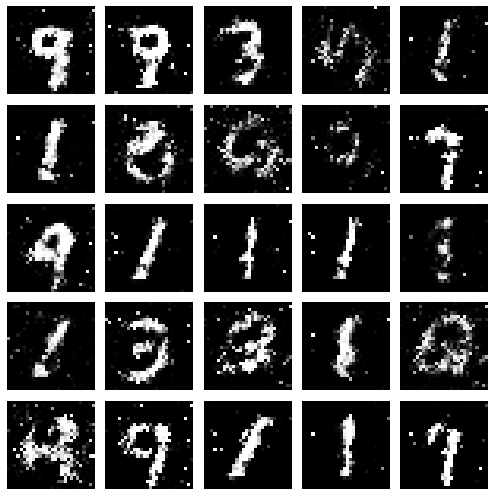

--------------- Epoch 2 ---------------


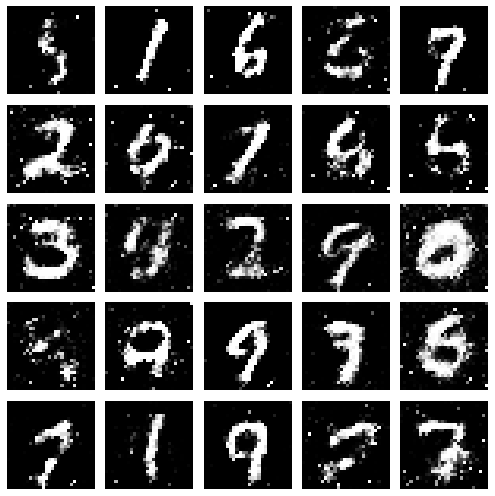

--------------- Epoch 3 ---------------


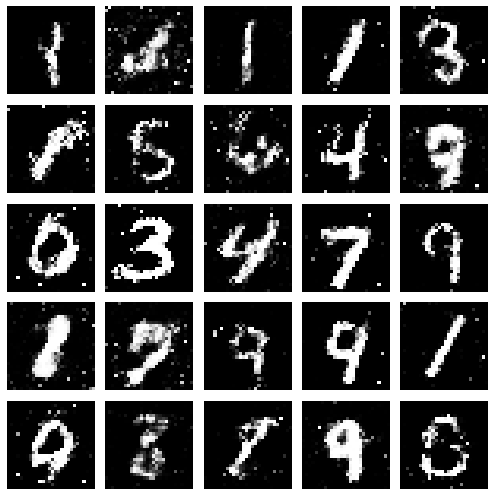

--------------- Epoch 4 ---------------


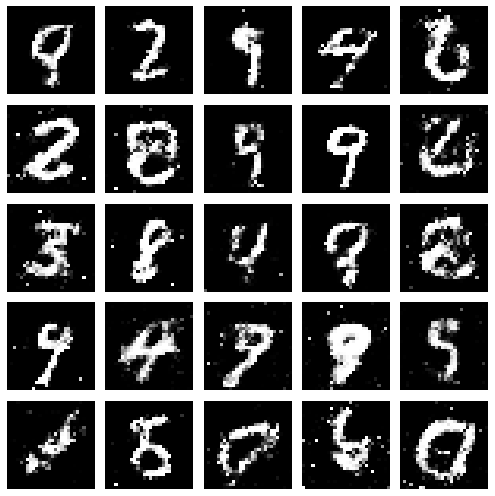

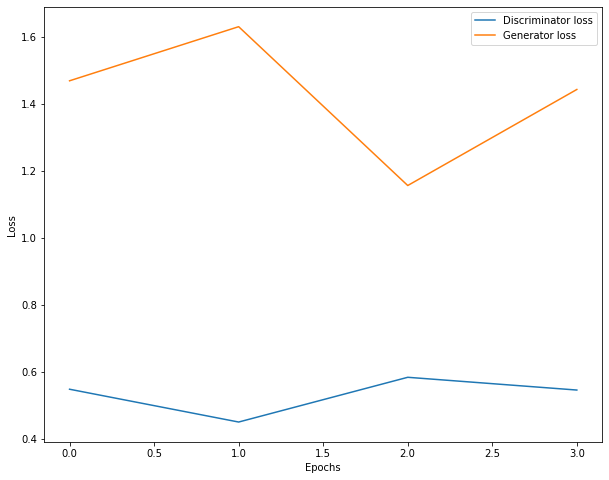

In [10]:
# Train GAN model
train(epochs=4, plt_frq=1, BATCH_SIZE=16)